In [2]:
!pip install gym

     |████████████████████████████████| 1.6MB 914kB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 1.5MB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.17.2-cp37-none-any.whl size=1650893 sha256=e62a4e6df1e57af2cafb4bfb6ce013f996e0c1e301479aa67d7e8183b8938770
  Stored in directory: /home/ben/.cache/pip/wheels/87/e0/91/f56e44e8062f8cd549673da49f59e1d4fe8b17398119b1d221
Successfully built gym


In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [14]:
# This is partly based on the (more sophisticated) implementation is in the pytorch repository:
# https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py
class PolicyNetwork(nn.Module):
    def __init__(self, lr, n_inputs, n_hidden, n_actions):
        """
        A network that learns a policy, i.e. a mapping
        from observations to actions.
        
        This sets up a two layer neural network,
        one hidden, one output, where each neuron
        in the output layer corresponds to one possible
        action.
        
        Parameters:
        -----------
        lr - learning rate
        input_dims - input dimensionality
        
        """
        super(PolicyNetwork, self).__init__()
        self.lr = lr
        self.fc1 = nn.Linear(n_inputs, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_actions)
        self.optimizer = T.optim.Adam(self.parameters(), lr=self.lr)
    
        self.device = T.device(
            'cuda:0'
            if T.cuda.is_available()
            else 'cpu:0'
        )
        self.to(self.device)
        
    def forward(self, observation):
        x = T.Tensor(
            observation.reshape(-1).astype('float32'),
        ).to(self.device)
        x = T.Tensor(observation).to(self.device)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x

In [15]:
class Agent:
    eps = np.finfo(np.float32).eps.item()

    def __init__(self, env, lr, params, gamma=0.99, epsilon=0.1):
        """
        Agents evaluate policies to take actions,
        and get rewards.
        
        gamma is the discount factor
        
        """
        self.env = env
        self.gamma = gamma
        self.actions = []
        self.rewards = []
        self.policy = PolicyNetwork(
            lr=lr,
            **params
        )
    
    def run(self):
        state = self.env.reset()
        probs = []
        rewards = []
        done = False
        observation = self.env.reset()
        t = 0
        while not done:
            action, prob = self.choose_action(observation)
            probs.append(prob)
            observation, reward, done, _ = self.env.step(action)
            rewards.append(reward)
            t += 1

        policy_loss = []
        returns = []
        R = 0
        for r in rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = T.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + self.eps)

        for log_prob, R in zip(probs, returns):
            policy_loss.append(-log_prob * R)

        if(len(policy_loss)) > 0:
            self.policy.optimizer.zero_grad()
            policy_loss = T.stack(policy_loss, 0).sum()
            policy_loss.backward()
            self.policy.optimizer.step()
            
        # for debugging:
        #print(policy_loss)
        return t
    
    def choose_action(self, observation):
        """choose an action given an observation

        The action is sampled according to the categorical
        distribution from our network.
        """        
        output = self.policy.forward(
            observation
        )
        action_probs = T.distributions.Categorical(output)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        action = action.item()
        self.actions.append(log_probs)
        # epsilon-greedy choice:
        #rand = np.random.random()
        #if rand <= self.epsilon:
        #    action = np.random.choice(self.action_space)
        return action, log_probs

In [16]:
import gym

env = gym.make('CartPole-v1')
env._max_episode_steps = 10000
input_dims = env.observation_space.low.reshape(-1).shape[0]
n_actions = env.action_space.n

In [18]:
import gym

env = gym.make('CartPole-v1')  # gym_tetris.tetris_env.TetrisEnv()
env._max_episode_steps = 10000
input_dims = env.observation_space.low.reshape(-1).shape[0]
n_actions = env.action_space.n

agent = Agent(
    env=env,
    lr=0.01,
    params=dict(n_inputs=input_dims, n_hidden=10, n_actions=n_actions),
    gamma=0.99,
)

In [20]:
update_interval = 100

scores = []
score = 0
n_episodes = 25000
stop_criterion = 1000
for i in range(n_episodes):
    mean_score = np.mean(scores[-update_interval:])
    if (i>0) and (i % update_interval) == 0:
        print('Iteration {}, average score: {:.3f}'.format(
            i, mean_score
        ))

    score = agent.run()
    scores.append(score)
    if score >= stop_criterion:
        print('Stopping. Iteration {}, average score: {:.3f}'.format(
            i, mean_score
        ))
        break

Stopping. Iteration 76, average score: 145.316


Text(0, 0.5, 'scores')

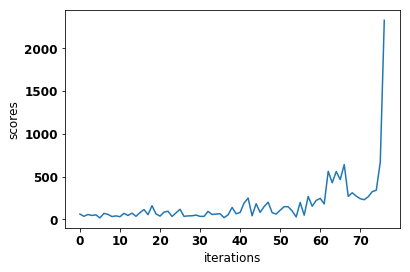

In [22]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
plt.plot(scores)
plt.xlabel('iterations')
plt.ylabel('scores')

In [35]:
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.dqn import DQNTrainer

ray.init(ignore_reinit_error=True)
trainer = PPOTrainer

# if you run this on colab you might want to set num_workers=2
analysis = tune.run(
    trainer,
    stop={'episode_reward_mean': 100},
    config={'env': 'CartPole-v0'},
    checkpoint_freq=1,
)

2020-06-20 14:10:10,156	INFO resource_spec.py:212 -- Starting Ray with 8.84 GiB memory available for workers and up to 4.44 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-20 14:10:10,685	INFO services.py:1170 -- View the Ray dashboard at localhost:8265


Trial name,status,loc
PPO_CartPole-v0_00000,RUNNING,


(pid=5356) 2020-06-20 14:10:14,743	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=5356) 2020-06-20 14:10:15,372	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=5356) 2020-06-20 14:10:15,372	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=5356) 2020-06-20 14:10:18,952	INFO trainable.py:217 -- Getting current IP.
(pid=5356) 2020-06-20 14:10:18,962	WARNING util.py:37 -- Install gputil for GPU system monitoring.
(pid=5353) 2020-06-20 14:10:19,778	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=5354) 2020-06-20 14:10:19,776	WARNING compression.py:16 -- lz4 not available, disabling sample compressi

Trial name,status,loc,iter,total time (s),ts,reward
PPO_CartPole-v0_00000,RUNNING,127.0.0.1:5356,1,11.8962,4000,22.0833


Result for PPO_CartPole-v0_00000:
  custom_metrics: {}
  date: 2020-06-20_14-10-39
  done: false
  episode_len_mean: 41.06
  episode_reward_max: 131.0
  episode_reward_mean: 41.06
  episode_reward_min: 8.0
  episodes_this_iter: 90
  episodes_total: 270
  experiment_id: bfb3f5a93ed148fe88672bb6128750de
  experiment_tag: '0'
  hostname: server
  info:
    grad_time_ms: 5649.65
    learner:
      default_policy:
        cur_kl_coeff: 0.30000001192092896
        cur_lr: 4.999999873689376e-05
        entropy: 0.6107953786849976
        entropy_coeff: 0.0
        kl: 0.019298221915960312
        model: {}
        policy_loss: -0.028672633692622185
        total_loss: 240.02420043945312
        vf_explained_var: 0.1258750855922699
        vf_loss: 240.0470428466797
    load_time_ms: 30.972
    num_steps_sampled: 8000
    num_steps_trained: 7936
    sample_time_ms: 4155.977
    update_time_ms: 272.502
  iterations_since_restore: 2
  node_ip: 127.0.0.1
  num_healthy_workers: 2
  off_policy_esti

Trial name,status,loc,iter,total time (s),ts,reward
PPO_CartPole-v0_00000,RUNNING,127.0.0.1:5356,2,20.2802,8000,41.06


Result for PPO_CartPole-v0_00000:
  custom_metrics: {}
  date: 2020-06-20_14-10-47
  done: false
  episode_len_mean: 65.45
  episode_reward_max: 200.0
  episode_reward_mean: 65.45
  episode_reward_min: 13.0
  episodes_this_iter: 39
  episodes_total: 309
  experiment_id: bfb3f5a93ed148fe88672bb6128750de
  experiment_tag: '0'
  hostname: server
  info:
    grad_time_ms: 5578.294
    learner:
      default_policy:
        cur_kl_coeff: 0.30000001192092896
        cur_lr: 4.999999873689376e-05
        entropy: 0.5686373710632324
        entropy_coeff: 0.0
        kl: 0.012524282559752464
        model: {}
        policy_loss: -0.018259910866618156
        total_loss: 625.0143432617188
        vf_explained_var: 0.06953061372041702
        vf_loss: 625.0289916992188
    load_time_ms: 21.257
    num_steps_sampled: 12000
    num_steps_trained: 11904
    sample_time_ms: 3753.686
    update_time_ms: 183.465
  iterations_since_restore: 3
  node_ip: 127.0.0.1
  num_healthy_workers: 2
  off_policy_

Trial name,status,loc,iter,total time (s),ts,reward
PPO_CartPole-v0_00000,RUNNING,127.0.0.1:5356,3,28.6778,12000,65.45


Result for PPO_CartPole-v0_00000:
  custom_metrics: {}
  date: 2020-06-20_14-10-56
  done: false
  episode_len_mean: 97.75
  episode_reward_max: 200.0
  episode_reward_mean: 97.75
  episode_reward_min: 17.0
  episodes_this_iter: 28
  episodes_total: 337
  experiment_id: bfb3f5a93ed148fe88672bb6128750de
  experiment_tag: '0'
  hostname: server
  info:
    grad_time_ms: 5547.185
    learner:
      default_policy:
        cur_kl_coeff: 0.30000001192092896
        cur_lr: 4.999999873689376e-05
        entropy: 0.5512956976890564
        entropy_coeff: 0.0
        kl: 0.00983278825879097
        model: {}
        policy_loss: -0.010200484655797482
        total_loss: 534.859619140625
        vf_explained_var: 0.29166412353515625
        vf_loss: 534.866943359375
    load_time_ms: 16.359
    num_steps_sampled: 16000
    num_steps_trained: 15872
    sample_time_ms: 3535.112
    update_time_ms: 138.885
  iterations_since_restore: 4
  node_ip: 127.0.0.1
  num_healthy_workers: 2
  off_policy_est

Trial name,status,loc,iter,total time (s),ts,reward
PPO_CartPole-v0_00000,RUNNING,127.0.0.1:5356,4,37.023,16000,97.75


Result for PPO_CartPole-v0_00000:
  custom_metrics: {}
  date: 2020-06-20_14-11-04
  done: true
  episode_len_mean: 124.98
  episode_reward_max: 200.0
  episode_reward_mean: 124.98
  episode_reward_min: 17.0
  episodes_this_iter: 21
  episodes_total: 358
  experiment_id: bfb3f5a93ed148fe88672bb6128750de
  experiment_tag: '0'
  hostname: server
  info:
    grad_time_ms: 5528.978
    learner:
      default_policy:
        cur_kl_coeff: 0.30000001192092896
        cur_lr: 4.999999873689376e-05
        entropy: 0.550544798374176
        entropy_coeff: 0.0
        kl: 0.0035177802201360464
        model: {}
        policy_loss: -0.005419825669378042
        total_loss: 239.95021057128906
        vf_explained_var: 0.42236775159835815
        vf_loss: 239.95460510253906
    load_time_ms: 13.676
    num_steps_sampled: 20000
    num_steps_trained: 19840
    sample_time_ms: 3404.621
    update_time_ms: 112.026
  iterations_since_restore: 5
  node_ip: 127.0.0.1
  num_healthy_workers: 2
  off_poli

Trial name,status,loc,iter,total time (s),ts,reward
PPO_CartPole-v0_00000,RUNNING,127.0.0.1:5356,5,45.3746,20000,124.98


Trial name,status,loc,iter,total time (s),ts,reward
PPO_CartPole-v0_00000,TERMINATED,,5,45.3746,20000,124.98
